In [1]:
%matplotlib inline

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Comparing distances
## 1) String distances
### 1.1) Hamming distance
Let $S$ and $T$ be two strings of same length. 
The Hamming distance between these two strings is simply $d(T,S) = |\{i \quad \forall i \in \{1,..., |S|\} \; | \; T[i]\neq S[i])$.
This distance represent the number of positions where both strings differ, or in other words, the minimum number of substitutions (e.g., errors) that changed one string into the other.

In [2]:
def hamming_distance(S,T):
    if len(S) != len(T):
        return None
    d = 0
    for i,s in enumerate(S):
        d += s != T[i]
    return d

In [3]:
hamming_distance("dans l'herbe noire les kobolds vont",
                 "dans l'herbr noird lzs kobolds vont")

3

In [4]:
hamming_distance("dans l'herbe noire les kobolds vont ",
                 " dans l'herbe noire les kobolds vont")

36

### 1.2) Levenshtein distance
In order to compare strings that have different lengths, or strings that undergo other kinds of modification (e.g., insertions, deletionss), the Levenshtein distance can be used.

Let $S$ and $T$ be two strings with possibly $|S| \neq |T|$, and let $\mathbb{1}_{S[i] \neq T[i]}$ be the indicator function that is equal to one when $S[i] \neq T[i]$ and 0 otherwise.

Let $\mathcal{L}_{S,T}(i,j)$ be the Levenshtein distance between the first $i$ characters of $S$ and the first $j$ characters of $T$:

+ if $min(i,j)=0$: $\quad \mathcal{L}_{S,T}(i,j)= max(i,j)$ 


+ Otherwise:

$$
    \mathcal{L}_{S,T}(i,j)= min
\begin{cases}
    \mathcal{L}_{S,T}(i-1,j) + 1\\
    \mathcal{L}_{S,T}(i,j-1) + 1\\
    \mathcal{L}_{S,T}(i-1,j-1) + \mathbb{1}_{S[i] \neq T[i]}
\end{cases}
$$

The Wagner–Fischer algorithm, can be used to compute the Levenshtein distance between $S$ and $T$. 
This dynamic programming algorithm, stores a matrix with the Levenshtein distances between all prefixes of both strings.
The last value of the matrix (at row $|S|$ and column $|T|$) stores the Levenshtein distance between both strings.

In [5]:
def Levenstein_distance(S,T,return_matrix=False):
    L = np.zeros((len(S)+1,len(T)+1))
    L[0,:] = range(len(T)+1)
    L[:,0] = range(len(S)+1)
    for i in range(1,len(S)+1):
        for j in range(1,len(T)+1):
            #print(L)
            comparison = int(S[i-1]!=T[j-1])
            L[i,j] = min([L[i-1,j] + 1, L[i,j-1] + 1, L[i-1,j-1] + comparison])
    if return_matrix:
        return L
    return(L[-1,-1])

Levenstein_distance("abc","abdc",True)

array([[0., 1., 2., 3., 4.],
       [1., 0., 1., 2., 3.],
       [2., 1., 0., 1., 2.],
       [3., 2., 1., 1., 1.]])

In [6]:
Levenstein_distance("dans l'herbe noire les kobolds vont ",
                   " dans l'herbe noire les kobolds vont le vent profond")

16.0

In [7]:
L = Levenstein_distance("dans l'herbe noire les kobolds vont ",
                        " dans l'herbe noire les kobolds vont le vent profond",
                        return_matrix=True)


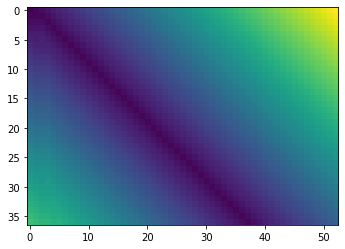

In [8]:
plt.imshow(L)

## 3) Alignment

### 3.1) Needleman-Wunsch - Global Alignment

This algorithm performs a global sequence alignment, i.e., it finds the best alignment over the entire length of two sequences $S$ and $T$. Intuitively the algorithm seeks an alignment that maximizes the number of element-to-element matches.
This dynamic programming algorithm is similar to the Wagner–Fischer algorithm.
The underlying scoring system defined by Needleman and Wunsch is equal to 1 for matches,  -1 for mismatches or indels.
Let $F_{S,T}(i,j)$ be the total number of matches scoring between the first $i$ elements of $S$ and the first $j$ elements of $T$:

+ If $i=0$ or $j=0$ $F_{S,T}(i,j) = -max(i,j)$ 

+ Otherwise:

$$
        \mathcal{F}_{S,T}(i,j)= max
\begin{cases}
    \mathcal{F}_{S,T}(i-1,j) - 1\\
    \mathcal{F}_{S,T}(i,j-1) - 1\\
    \mathcal{F}_{S,T}(i-1,j-1) - \mathbb{1}_{S[i] \neq T[i]} + \mathbb{1}_{S[i] = T[i]}
\end{cases}
$$

+ Record the values of $F_{S,T}(i,j)$ in a matrix

+ For each element in the matrix, record the decision that was made to reach this value: 
    + $\mathcal{F}_{S,T}(i-1,j)$
    + $\mathcal{F}_{S,T}(i,j-1)$
    + or $\mathcal{F}_{S,T}(i-1,j-1)$).  

+ In order to find the best alignment, 

+ To find the best alignment we start from the last element of the matrix (at row $|S|$ and column $|T|$) and we move backwards until we reach the first one (at row $0$ and column $0$). At each position we check which decision leaded to the actual solution (many solutions are sometimes possible, in this case you can keep all of them).
    + If the decision was $F_{S,T}(i-1,j)$ then it means that $S[i]$ is aligned with a gap
    + If the decision was $F_{S,T}(i,j-1)$ then $T[j]$ is aligned with a gap
    + If it was $F_{S,T}(i-1,j-1)$ then $S[i]$ and $T[j]$ are aligned. You can use the records you made in the previous step or recompute the possibilities ... both are possible.
\end{itemize}

In [9]:
def NWmatrix2strings(S,T,D):
    S_WITH_GAP = -1
    T_WITH_GAP = 1
    S_T_ALIGN = 0
    i = D.shape[0]-1
    j = D.shape[1]-1
    S_aligned = ""
    T_aligned = ""
    while i > 0 or j > 0:
        #print(i,j,T[j-1],S[i-1],D[i,j])
        if D[i,j] == S_WITH_GAP:
            S_aligned = S[i-1]+S_aligned
            T_aligned = "_"+T_aligned
            #print(S_aligned,T_aligned)
            i -= 1
        elif D[i,j] == T_WITH_GAP:
            T_aligned = T[j-1]+ T_aligned
            S_aligned = "_"+S_aligned
            #print(S_aligned,T_aligned)
            j -= 1
        elif D[i,j] == S_T_ALIGN:
            S_aligned = S[i-1] + S_aligned
            T_aligned = T[j-1] + T_aligned
            #print(S_aligned,T_aligned)
            j -= 1
            i -= 1
    return(S_aligned,T_aligned)
    
def Needleman_Wunch(S,T,return_matrix=False):
    T_WITH_GAP = 1
    S_WITH_GAP = -1
    S_T_ALIGN = 0
    decision = [T_WITH_GAP,S_WITH_GAP,S_T_ALIGN]
    F = np.zeros((len(S)+1,len(T)+1))
    F[0,:] = range(len(T)+1)
    F[:,0] = range(len(S)+1)
    F *= -1
    D = np.zeros((len(S)+1,len(T)+1))
    D[0,1:] = T_WITH_GAP 
    D[1:,0] = S_WITH_GAP 
    for i in range(1,len(S)+1):
        for j in range(1,len(T)+1):
            comparison = int(S[i-1]==T[j-1]) # * 10
            options = [F[i,j-1] - 1, F[i-1,j] - 1, F[i-1,j-1] + comparison]
            F[i,j] = options[0]
            D[i,j] = T_WITH_GAP
            for o,val in enumerate(options):
                if val > F[i,j]:
                    F[i,j] = val
                    D[i,j] = decision[o]
    if return_matrix:
        return F,D

In [10]:
S = "dans l'herbe noire les gros kobolds vont "
T = " dans l'herbe noire les kobolds vont le vent profond"
F,D = Needleman_Wunch(S,T,True)
NWmatrix2strings(S,T,D)

("_dans l'herbe noire les gr_o__s kobolds vont _______",
 " dans l'herbe noire les kobolds vont le vent profond")

In [11]:
print(F)

[[ -0.  -1.  -2. ... -50. -51. -52.]
 [ -1.   0.   0. ... -48. -49. -50.]
 [ -2.  -1.   0. ... -46. -47. -48.]
 ...
 [-39. -37. -35. ...  19.  19.  18.]
 [-40. -38. -36. ...  21.  20.  19.]
 [-41. -39. -37. ...  23.  22.  21.]]


In [12]:
print(D)

[[ 0.  1.  1. ...  1.  1.  1.]
 [-1.  0.  0. ...  1.  1.  1.]
 [-1. -1.  0. ...  1.  1.  1.]
 ...
 [-1. -1. -1. ...  1.  0.  1.]
 [-1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  1.  1.  1.]]


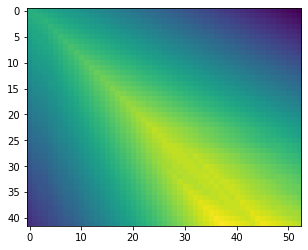

In [13]:
plt.imshow(F)

### 3.2) Smith-Waterman - local Alignment

Smith-Waterman algorithm performs local sequence alignment, i.e., it finds alignments shorter than the entire sequences.
This kind of alignments is particularly useful when we compare two sequences that are very different, but that may share some local regions with high similarity.
The Smith-Waterman algorithm is very similar to the Needleman-Wunsch method.
The only difference in terms of instructions to build the matrix is the following line: 

+ If $i=0$ or $j=0$ $F_{S,T}(i,j) = -max(i,j)$ (Needleman-Wunch)
+ + If $i=0$ or $j=0$ $F_{S,T}(i,j) = 0$ (Smith-Waterman)

Moreover, instead of starting at position $|S|$ and $|T|$ to track back the alignment, one should start at the maximal position in the matrix


In [14]:
def SWmatrix2strings(S,T,D,F):
    S_WITH_GAP = -1
    T_WITH_GAP = 1
    S_T_ALIGN = 0
    i,j = np.unravel_index(F.argmax(),F.shape)
    print(i,j)
    S_aligned = ""
    T_aligned = ""
    while i > 0 and j > 0:
        #print(i,j,T[j-1],S[i-1],D[i,j])
        if D[i,j] == S_WITH_GAP:
            S_aligned = S[i-1]+S_aligned
            T_aligned = "_"+T_aligned
            #print(S_aligned,T_aligned)
            i -= 1
        elif D[i,j] == T_WITH_GAP:
            T_aligned = T[j-1]+ T_aligned
            S_aligned = "_"+S_aligned
            #print(S_aligned,T_aligned)
            j -= 1
        elif D[i,j] == S_T_ALIGN:
            S_aligned = S[i-1] + S_aligned
            T_aligned = T[j-1] + T_aligned
            #print(S_aligned,T_aligned)
            j -= 1
            i -= 1
    return(S_aligned,T_aligned)

def Smith_Waterman(S,T,return_matrix=False):
    T_WITH_GAP = 1
    S_WITH_GAP = -1
    S_T_ALIGN = 0
    decision = [T_WITH_GAP,S_WITH_GAP,S_T_ALIGN]
    F = np.zeros((len(S)+1,len(T)+1))
    D = np.zeros((len(S)+1,len(T)+1))
    D[0,1:] = T_WITH_GAP 
    D[1:,0] = S_WITH_GAP 
    for i in range(1,len(S)+1):
        for j in range(1,len(T)+1):
            comparison = int(S[i-1]==T[j-1])
            options = [F[i,j-1] - 1, F[i-1,j] - 1, F[i-1,j-1] + comparison]
            F[i,j] = options[0]
            D[i,j] = T_WITH_GAP
            for o,val in enumerate(options):
                if val > F[i,j]:
                    F[i,j] = val
                    D[i,j] = decision[o]
    if return_matrix:
        return F,D

In [15]:
S = "un buisson gifle l'oeil au passant. dans l'herbe noir(e les kobolds vont "
T = " dans l'herbe noire les kobolds vont le vent profond pleure on veut croire"
F,D = Smith_Waterman(S,T,True)
SWmatrix2strings(S,T,D,F)

73 37


(" dans l'herbe noir(e les kobolds vont ",
 " dans l'herbe noir_e les kobolds vont ")

In [16]:
print(F)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 11. 10. 10.]
 [ 0.  0.  0. ... 11. 11. 10.]
 [ 0.  1.  0. ... 11. 11. 11.]]


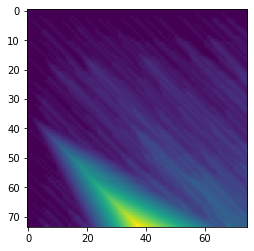

In [17]:
plt.imshow(F)
plt.show()